### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy import plotting
import pandas as pd
from scipy import stats
import subjects
from neuropy.analyses import detect_local_sleep_epochs

sessions = (
    subjects.sd.ratJday1
    +subjects.sd.ratKday1
    + subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratRday2
    + subjects.sd.ratUday4
    + subjects.sd.ratVday2
)

### Bimodoality in firing rate during sleep deprivation
- Something similar to Ji and Wilson 2007, to see if we have off periods during sleep deprivation that can clearly be seen as a peak in sleep deprivation.
- Didn't find any bimodality in my data tried using all spikes and only pyramidal neurons.

In [24]:
mua=[]
for sub,sess in enumerate(sessions):
    post = sess.paradigm['post'].flatten()
    period = [post[0],post[0]+5*3600] 
    binspk = sess.neurons.get_neuron_type('pyr').time_slice(*period).get_binned_spiketrains(bin_size=0.1)
    n_spikes = binspk.spike_counts.sum(axis=0)
    mua.append(n_spikes/n_spikes.max())
mua = np.concatenate(mua)

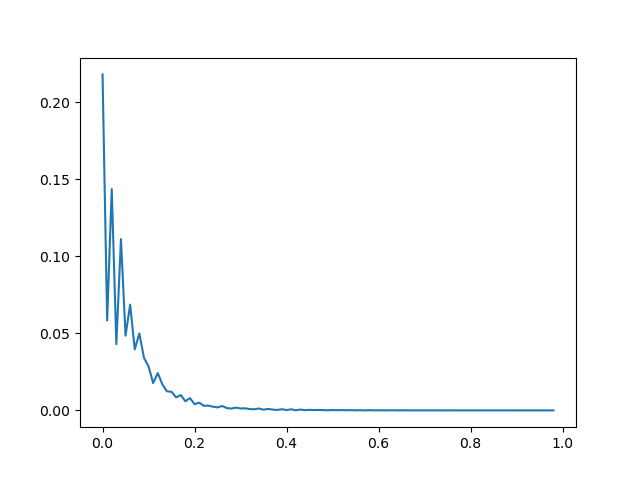

In [27]:
_,ax = plt.subplots()
mua_bins = np.arange(0,1,0.01)
mua_hist= np.histogram(mua,mua_bins)[0]
mua_hist = mua_hist/np.sum(mua_hist)
ax.plot(mua_bins[:-1],mua_hist)

### Pooled off period detection

In [ ]:
from neuropy.analyses import detect_local_sleep_epochs
for sub,sess in enumerate(sessions):
    post = sess.paradigm['post'].flatten()
    period = [post[0],post[0]+5*3600] 
    mua =sess.mua.time_slice(*period)
    smth_mua = mua.get_smoothed(sigma=0.02)

    off = detect_local_sleep_epochs(smth_mua)
    off.save(sess.filePrefix.with_suffix('.off'))

### Occurence rate during sleep deprivation

In [ ]:
off_rate_df = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    period = [post[0], post[0] + 5* 3600]
    off = sess.off.starts

    binsz = 3600
    n_bins = np.diff(period)/ binsz
    sd_bin = np.arange(n_bins + 1) * binsz + period[0]
    hist_off = np.histogram(off, bins=sd_bin)[0]

    off_rate_df.append(
        pd.DataFrame(
            {
                "rate": hist_off / binsz,
                "Zt": (sd_bin[:-1] - sd_bin[0]) / 3600 +1,
                "sub": sub,
                "grp": sess.tag,
            }
        ),
    )
off_rate_df = pd.concat(off_rate_df,ignore_index=True)
# subjects.GroupData().save(pbe_rate_df,'off_rate')

In [ ]:
%matplotlib widget
import seaborn as sns
from neuropy.plotting import Fig

fig = Fig(grid=(5, 4),fontsize=10)

for i, grp in enumerate(["SD"]):
    df = off_rate_df[off_rate_df["grp"] == grp]
    ax = plt.subplot(fig.gs[i])
    sns.lineplot(
        data=df,
        x="Zt",
        y="rate",
        ax=ax,
        hue="sub",
        legend=False,
        marker='o',
        palette=['#f94848']*7
        # palette="#BDBDBD",
        # ls="--",
    )
    # sns.lineplot(
    #     data=df,
    #     x="Zt",
    #     y="rate",
    #     estimator=np.median,
    #     ax=ax,
    #     legend=False,
    #     color='k',
    #     ls="--",
    #     ci=None,
    #     lw=2,
    # )
    # ax.set_yscale('log')
    # ax.set_ylim([0.08, 0.65])
    # ax.set_xticks(np.arange(1, 10, 2))
ax.set_xticks(np.arange(1,6))
ax.set_xlabel('Zt time (h)')
ax.set_title('Off periods rate')
ax.set_ylabel('Rate (Hz)')
ax.set_xlim([0,6])
# figure.savefig(subjects.figpath_sd/'ripple_rate')


### Total duration during SD

In [ ]:
off_duration = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    zt = np.array([0,4])
    period = zt * 3600 + post[0]

    for i, t in enumerate(period):

        off_duration.append(
            pd.DataFrame(
                {
                    "Zt": f'Zt{zt[i]}-{zt[i]+1}',
                    "off_duration": [sess.off.time_slice(t, t + 3600).durations.sum()],
                    "grp": sess.tag,
                    "sub": sub,
                }
            ),
        )

off_duration = pd.concat(off_duration,ignore_index=True)
subjects.GroupData().save(off_duration, "off_total_duration")


In [ ]:
%matplotlib widget
import seaborn as sns
from neuropy import plotting

# plt.figure(figsize=(8,11))
fig = plotting.Fig(grid=(4, 3),fontsize=12)

for i, grp in enumerate(["SD"]):
    data = off_duration[off_duration["grp"] == grp]
    ax = plt.subplot(fig.gs[i])
    sns.lineplot(
        data=data,
        x="Zt",
        y="off_duration",
        hue="sub",
        marker="o",
        palette=["#f94848"] * 7,
        ax=ax,
        legend=None,
    )
    ax.set_xlim([-1,2])

ax.set_xlabel('Zt time (h)')
ax.set_ylabel('Time in off (s)')
ax.set_title('OFF periods during\nsleep deprivation')
# ax.set_ylim([30,450])



### Off periods vs rpls/pbe CCG
- In the hippocampus following PBE/SWR there is a brief period of silence. When plotting the ccg between ripple-stops and off-starts, we see a clear peak around zero. This suggests, off periods detected include post-SWR silence periods too, making it hard to interpret sleep deprivation-induced off-periods in the hippocampus (unlike what was observed in the cortex in Vyazovskiy et al. 2011).
- One possible way to analayze this can be assessing mua activity within these off-periods and see if later in sleep deprivation if neurons more or less silent compared to earlier in sleep deprivation.

In [ ]:
from neuropy.utils.ccg import correlograms

ccg_df = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    period = [post[0], post[0] + 5 * 3600]
    off_durations = sess.off.durations
    off = sess.off.stops
    rpls = sess.ripple.time_slice(*period).starts

    times = np.concatenate([rpls, off])
    ids = np.concatenate([np.ones_like(rpls), 2 * np.ones_like(off)])
    sort_ind = np.argsort(times)

    ccg = correlograms(
        times[sort_ind],
        ids[sort_ind].astype("int"),
        sample_rate=1250,
        bin_size=0.001,
        window_size=0.5,
    )
    ccg_df.append(
        pd.DataFrame({"ccg": ccg[0, 1, :], "time": np.linspace(-0.25, 0.25, 501)}),
    )

ccg_df = pd.concat(ccg_df,ignore_index=True)

In [ ]:
from neuropy import plotting
import seaborn as sns

fig = plotting.Fig(grid=(4,3),fontsize=12)

ax = plt.subplot(fig.gs[0])
sns.lineplot(data=ccg_df,x='time',y='ccg',ax=ax,ci=None,color='#f94848')
# ax.set_xlim([-0.03,0.03])
ax.set_ylim([0,48])
ax.axvline(0,ls='--',color='k')
ax.set_title('End of Off period vs Ripples')
ax.set_xlabel('Time from start of ripple (ms)')
ax.set_ylabel('Counts')

### Ripples around start and stop of OFF periods

In [ ]:
from neuropy.utils.ccg import correlograms

ccg_df = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    period = [post[0], post[0] + 5 * 3600]
    off_durations = sess.off.durations
    off_starts = sess.off.starts
    off_stops = sess.off.stops
    # rpl_starts = sess.ripple.time_slice(*period).starts
    rpl_starts = sess.ripple.time_slice(*period).to_dataframe().peaktime

    times = np.concatenate([rpl_starts, off_starts, off_stops])
    ids = np.concatenate(
        [
            np.ones_like(rpl_starts),
            2 * np.ones_like(off_starts),
            3 * np.ones_like(off_stops),
        ]
    )
    sort_ind = np.argsort(times)

    ccg = correlograms(
        times[sort_ind],
        ids[sort_ind].astype("int"),
        sample_rate=1250,
        bin_size=0.001,
        window_size=0.5,
    )

    df1 = pd.DataFrame(
        {
            "ccg": ccg[1, 0, :],
            "time": np.linspace(-0.25, 0.25, 501)-0.1,
            "grp": "from_start",
        }
    )
    df2 = pd.DataFrame(
        {"ccg": ccg[2, 0, :], "time": np.linspace(-0.25, 0.25, 501)+0.1, "grp": "from_stop"}
    )

    ccg_df.append(df1)
    ccg_df.append(df2)


ccg_df = pd.concat(ccg_df, ignore_index=True)


In [ ]:
from neuropy import plotting
import seaborn as sns

fig = plotting.Fig(grid=(4,2),fontsize=12)

ax = plt.subplot(fig.gs[0])
sns.lineplot(data=ccg_df,x='time',y='ccg',ax=ax,ci='sd',palette=['#f94848']*2,hue='grp')
# ax.set_xlim([-0.03,0.03])
ax.legend([],frameon=False)
ax.set_ylim([0,48])
ax.axvline(-0.1,ls='--',color='k')
ax.axvline(0.1,ls='--',color='k')
ax.set_xticks([-0.25,-0.1,0.1,0.25],[-0.25,'start','stop',0.25])
ax.set_title('Ripples around off periods')
ax.set_xlabel('Relative to Off periods (ms)')
ax.set_ylabel('Counts')